<a href="https://colab.research.google.com/github/inmas-training/fa21-statistical-methods-workshop/blob/main/project-classification-counts-in-pandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Your Turn: Counting Classifications

Please note, this is an extra problem for students who are already fluent with Pandas.

**Warning: This problem will take a variable amount of time to setup depending on the time of day!**

In this exercise, we'll try to classify everyday objects from the
[Alma webcam](https://illinois.edu/about/almacam.html) using the [You Only Look Once (YOLO) v3](https://pjreddie.com/darknet/yolo/).

(Fun fact, there's another web camera on the quad called "[the Quadcam](https://illinois.edu/about/quadcam.html)", but the resolution is problematic with this algorithm.)

Prior to beginning this problem, please make sure that a **GPU is enabled** by going to:

```
Runtime -> Change runtime type -> Hardware Accelerator -> GPU
```

Next, please run the following setup code to setup the environment for predicting with YOLO v3. In-depth instructions follow immediately after the setup code.

## Setup Code 

Portions of the setup code are based on [yolov3-tf2](https://colab.research.google.com/github/zzh8829/yolov3-tf2/blob/master/colab_gpu.ipynb) document. Further modifications were made to simply the process of initializing the model and stablize the model across tensorflow versions. Please run each code chunk in order. Failure to do so may result in issues when trying to detect an image with YOLO v3.

In [ ]:
# Suppress output
%%capture

# 1. Setup the model environment
!git clone https://github.com/zzh8829/yolov3-tf2
# Switch into the model directory
%cd yolov3-tf2/

# Install additional packages (note, we avoid using the included requirements.txt)
!pip install opencv-python==4.1.1.26 lxml tqdm

In [ ]:
# Suppress output
%%capture

# 2. Retrieve the pretrained model
!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights
!python convert.py

In [ ]:
# Verify we are in the yolov3-tf2 directory
!pwd 
# Failure to do so will result in checkpoints not being found.

# Check contents of the yolov3-tf2 directory
!ls

/content/yolov3-tf2
checkpoints	 data		  README.md		train.py
colab_gpu.ipynb  detect.py	  requirements-gpu.txt	yolov3_tf2
conda-cpu.yml	 detect_video.py  requirements.txt
conda-gpu.yml	 docs		  setup.py
convert.py	 LICENSE	  tools


In [ ]:
# 3. Structure the YOLO model 
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import numpy as np
import requests
%tensorflow_version 2.x
import tensorflow as tf
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs

# Ensure no duplicate flags exist if code chunk is re-run multiple times.
def del_all_flags():
    for name in list(flags.FLAGS):
        if name in ['classes', 'weights', 'tiny',
                    'size', 'image', 'tfrecord', 'output',
                    'num_classes']: 
            delattr(flags.FLAGS, name)

del_all_flags()
# Remove flags

# Define set of flags required for processing data.
flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

# Explicitly request flags be parsed prior to accessing them in the next code chunk.
# https://github.com/google/python-gflags/issues/37#issuecomment-297800637
FLAGS([sys.argv])

## Change if needed to allow for classification with lower probabilities
## in exercise (b) 
FLAGS.yolo_score_threshold = 0.5

# Verify that a GPU is available
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
  print("GPU Detected ...")
else:
  print("GPU not found ... \n\
         Please make sure to enable a GPU prior to continuing.\n\
         Follow notes at the start of the problem")

GPU Detected ...


In [ ]:
# Bring online the model
if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

# Ensure model loads correctly
yolo.load_weights(FLAGS.weights).expect_partial()
print('Loaded: weights ... ')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
print('Loaded: classes ... ')


Loaded: weights ... 
Loaded: classes ... 


## (a) Detecting Objects

In this exercise, we're interested in detecting within images from the Alma mater webcam these object classes:

- person
- bicycle
- backpack
- handbag
- cell phone

Please use the spelling given above as it matches with classes recognized by the YoloV3 network (see [data/coco.names](https://github.com/pjreddie/darknet/blob/master/data/coco.names) for details.)

Obtain the images from:

 - https://coatless.github.io/alma-cam/alma-cam-1.png
 - https://coatless.github.io/alma-cam/alma-cam-2.png
 - https://coatless.github.io/alma-cam/alma-cam-3.png
 - https://coatless.github.io/alma-cam/alma-cam-4.png
 - https://coatless.github.io/alma-cam/alma-cam-5.png
 - https://coatless.github.io/alma-cam/alma-cam-6.png
 - https://coatless.github.io/alma-cam/alma-cam-7.png
 - https://coatless.github.io/alma-cam/alma-cam-8.png
 - https://coatless.github.io/alma-cam/alma-cam-9.png
 - https://coatless.github.io/alma-cam/alma-cam-10.png

So, the first image can be retrieved with:

```
https://coatless.github.io/alma-cam/alma-cam-1.png
```

Dynamically construct a Pandas dataframe that contains the ImageID and a count of each object under the given class. e.g.

| ImageID    | Person | Bicycle | Backpack | handbag | cell phone   |
|:-----------|--------|---------|----------|---------|--------------|
| example-1  | 0      |     1   | 1        | 0       |    0         |

To help in this endeavor, the author has made available a set of functions to  model with the existing network. Please use these functions to load images and model the data.


In [ ]:
# Retrieve image from online
def download_img(url):
  return requests.get(url).content

# Internal function that pads the image with an additional dimension
# such that an image goes from height x width to examples x height x width
# and standardize the image with a fixed size
def clean_img(img_raw, img_size = FLAGS.size):
  # Expand dimension to obtain a single image
  img = tf.expand_dims(img_raw, 0)
  # Transform image to specific size
  img = transform_images(img, img_size)
  return img

# Load the image downloaded from the internet
def load_img_binary(img_dl, channels = 3, img_size = FLAGS.size):
  img_raw = tf.image.decode_image(img_dl, channels = channels)
  img = clean_img(img_raw, img_size)
  return img, img_raw
  
# Load the image found locally
def load_img_file(path, channels = 3, img_size = FLAGS.size):
  # Load image file from path
  img, img_raw = load_img_binary(open(path, 'rb').read(), 
                        channels, img_size)
  return img, img_raw

# Perform a classification with the YOLO network
def classify_img(img, yolo):
  t1 = time.time()
  boxes, scores, classes, nums = yolo(img)
  t2 = time.time()
  print(f'Elapsed time: {t2 - t1} ...')
  return boxes, scores, classes, nums

# Traceback of the detections found in the image
# Useful for understanding what was detected in a single image
def img_detect(boxes, scores, classes, nums, class_names):
  print('Detections ...')
  for i in range(nums[0]):
    classes_found = class_names[int(classes[0][i])]
    class_confidence = np.array(scores[0][i])
    box_outline = np.array(boxes[0][i])
    print(f'\t{classes_found}, {class_confidence}, {box_outline}')

# Render the image with detected object in boxes
def img_draw_boxes(img, img_raw, boxes, scores, classes, nums, class_names):
  img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
  img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
  from IPython.display import Image, display
  display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))



Consider the following image from a UIUC blog:

In [ ]:
from IPython.display import Image
Image(url='https://blogs.illinois.edu/files/6231/545166/117021.jpg', width=500)

The YOLOv3 algorithm could be used by:

Elapsed time: 0.15280437469482422 ...
Detections ...
	person, 0.9938567876815796, [0.553931  0.7404986 0.6068485 0.9699463]
	person, 0.992772102355957, [0.4844485  0.8200235  0.54835624 1.005589  ]
	person, 0.9852887988090515, [0.05976507 0.8181028  0.13217013 0.9998931 ]
	person, 0.9796091914176941, [0.04452583 0.513525   0.96492016 0.9459822 ]
	person, 0.9764063954353333, [0.44659895 0.74617267 0.49925917 0.9744003 ]
	person, 0.9568382501602173, [5.6389533e-04 7.3764223e-01 4.7801137e-02 9.3712097e-01]
	person, 0.9545536041259766, [0.80247855 0.6636031  0.8359437  0.84464234]
	person, 0.9484509229660034, [0.2713049  0.72548854 0.3140316  0.9231179 ]
	person, 0.9013041853904724, [0.9529335 0.6823874 0.9966491 0.8689783]
	person, 0.8018627166748047, [0.1834395  0.7712548  0.22755504 0.9329134 ]
	person, 0.7673454284667969, [0.91145086 0.6747239  0.94935536 0.84592074]
	person, 0.7646762132644653, [0.6205256  0.79219544 0.66168165 0.8836546 ]
	person, 0.7563082575798035, [0.31593165 0.7

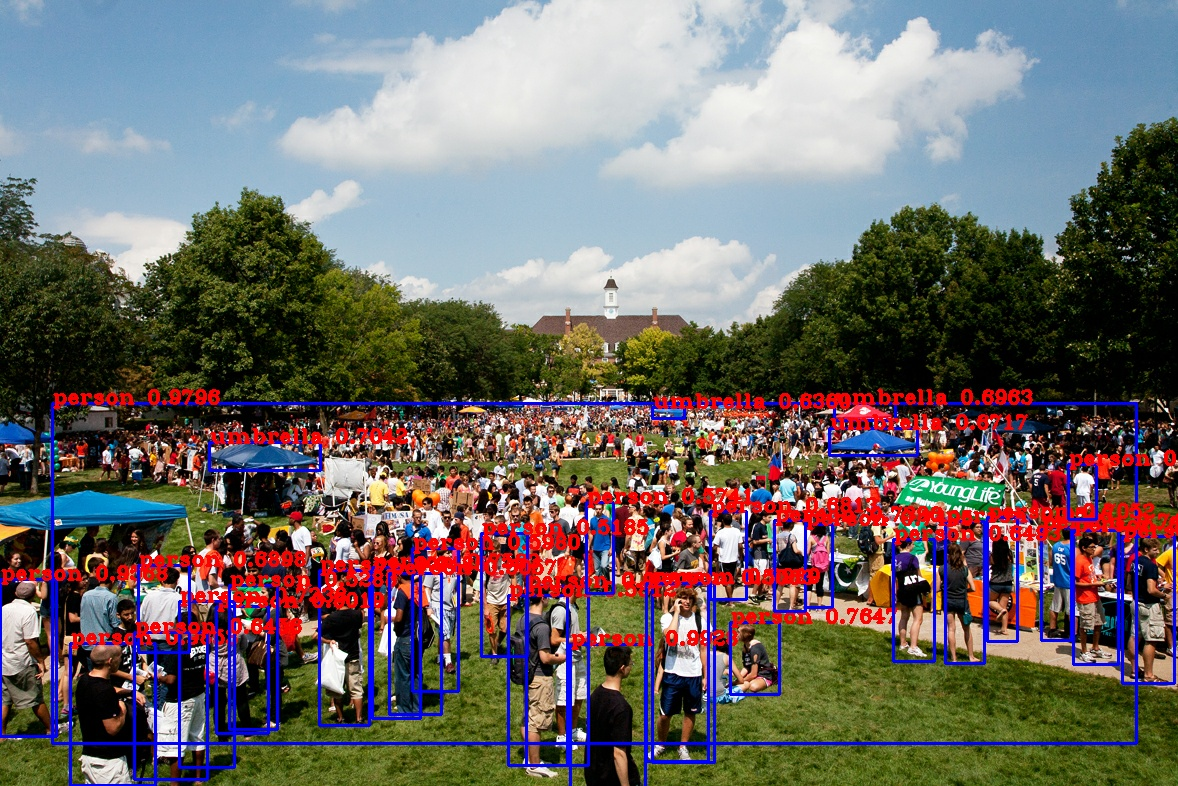

In [ ]:
# Example image download and read 
img, img_raw = load_img_binary(
    download_img("https://blogs.illinois.edu/files/6231/545166/117021.jpg")
)

boxes, scores, classes, nums = classify_img(img, yolo)
img_detect(boxes, scores, classes, nums, class_names)
img_draw_boxes(img, img_raw, boxes, scores, classes, nums, class_names)

In the last code statement, we're saving output from the model into four variables:

- `boxes`: Bounding box regions of where the object detected lies 
  - e.g. blue boxes in the above image
- `nums`: Number of classifications per image.
  - e.g. number of blue boxes in the above image
- `scores`: Probabilities of the different classes the model was trained for.
  - e.g. the red numeric values in the above image (e.g. top-left is 0.9796)
- `classes`: Labels of objects whose `score` exceeded a classification threshold given by `FLAGS.yolo_score_threshold = 0.2`. 
  - e.g. the red names in the above image (e.g. person)

From the above variables, we are only interested in the `nums` and `classes` variables. In particular, we want to know how many items were detected in the image via `nums[0]` and the class that was detected, `classes[0][j]`. We can observe this being the driving influence behind the custom print method in `img_detect()`. 

In [ ]:
import pandas as pd

## code here

# Consider structuring the problem by:
# 1. Generating a list of images
# 2. Classifying each image
# 3. Storing the results inside of a data.frame

url_base = "https://coatless.github.io/alma-cam/"
urls = [f"{url_base}/alma-cam-{i}.png" for i in range(1, 11)]

# This makes urls have between:
# https://coatless.github.io/alma-cam/alma-cam-1.png

# Pre-populate a data frame
df_classes = ['person', 'bicycle', 'backpack', 'handbag', 'cell phone']
cols = ['ImageID'] + df_classes
df = pd.DataFrame(columns = cols)

# Loop over the images here

## (b) Upload and run your own image! 

In this exercise, you will repeat the prior exercise but instead you will select the classes that should be detected from an image you supply.

View all possible classes by exploring the [data/coco.names](https://github.com/pjreddie/darknet/blob/master/data/coco.names) class names file.


In [ ]:
# Upload an image file 
uploaded = files.upload()

Please use the name of the uploaded file in place of the `colab-logo.png`. 

In [ ]:
from IPython.display import Image
# Display the embedded image in the notebook.
Image('colab-logo.png', width=100)

In [ ]:
# ... code here ... 